In [1]:
import pandas as pd

file_name = 'data/1-s2.0-S1097276521002665-mmc6.xlsx'
different_genes_xls = pd.ExcelFile(file_name)

In [2]:
xls_sheets = [sheets for sheets in different_genes_xls.sheet_names if sheets[:2] == '5B']

In [3]:
import joblib 
out_file_path = './'
gene_signature_dir = out_file_path + 'gene_signatures/'
out_filename = gene_signature_dir + 'metabolism_terms_mouse.pickle'
metabolism_sig = joblib.load(out_filename)

# Jaccard Index

In [4]:
for sheet_name in xls_sheets:
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    diff_gene_set = set([item.upper() for item in df[df['log2FC']>1]['index'].tolist()])
    for pathway_key in metabolism_sig:
        pct_overlap = len(diff_gene_set.intersection(metabolism_sig[pathway_key]))/(len(diff_gene_set)+len(metabolism_sig[pathway_key]))
        if pct_overlap > 0:
            print(sheet_name, pathway_key, pct_overlap)

5BA_diffexpr-nonnaive-cluster1 KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_KERATAN_SULFATE 0.030303030303030304
5BA_diffexpr-nonnaive-cluster1 KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY 0.002680965147453083
5BA_diffexpr-nonnaive-cluster1 KEGG_MM_NOD-LIKE_RECEPTOR_SIGNALING_PATHWAY 0.012987012987012988
5BB_diffexpr-nonnaive-cluster2 KEGG_MM_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_HEPARAN_SULFATE_HEPARIN 0.015384615384615385
5BB_diffexpr-nonnaive-cluster2 KEGG_MM_PI3K-AKT_SIGNALING_PATHWAY 0.005050505050505051
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_GLYCOLYSIS_GLUCONEOGENESIS 0.012875536480686695
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_FRUCTOSE_AND_MANNOSE_METABOLISM 0.00966183574879227
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_PURINE_METABOLISM 0.008902077151335312
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_PYRIMIDINE_METABOLISM 0.018726591760299626
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_GLYCINE_SERINE_AND_THREONINE_METABOLISM 0.0048543689320388345
5BD_diffexpr-nonnaive-cluster4 KEGG_MM_CYSTEINE_AND_METHIONINE_METABO

In [5]:
from utils import *

M = 9822
res = {'cluster_name': [], 'pathway_name': [], 'p-value': []}
for sheet_name in xls_sheets:
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    diff_gene_set = set([item.upper() for item in df[df['log2FC']>1]['index'].tolist()])
    for pathway_key in metabolism_sig:
        n = len(metabolism_sig[pathway_key])
        N = len(diff_gene_set)
        x = len(diff_gene_set.intersection(metabolism_sig[pathway_key]))
        pct_overlap = x/(N+n)
        
        if pct_overlap > 0:
            p_val = hypergeometric_test(total_genes_expressed=M, n_genes_of_interest=n, 
                                        n_genes_picked=N, n_overlap=x)
            res['cluster_name'].append(sheet_name)
            res['pathway_name'].append(pathway_key)
            res['p-value'].append(p_val)
#         else:
#             res['cluster_name'].append(sheet_name)
#             res['pathway_name'].append(pathway_key)
#             res['p-value'].append(1)

In [6]:
df = pd.DataFrame.from_dict(res)

In [7]:
p_adj = adjust_p_value_bh(df['p-value'])

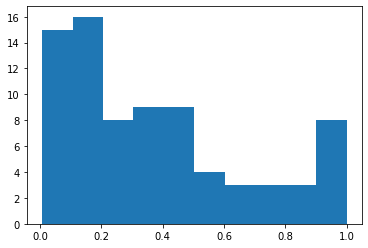

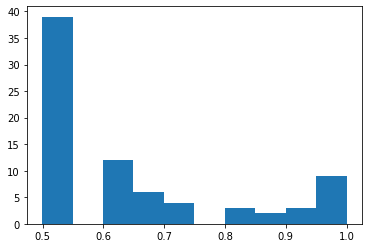

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['p-value'], bins=10)
# plt.xlim([0, 0.9])
# plt.ylim([0, 100])
plt.show()
plt.hist(p_adj, bins=10)
plt.show()

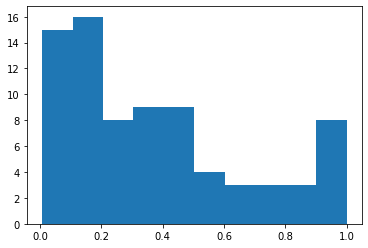

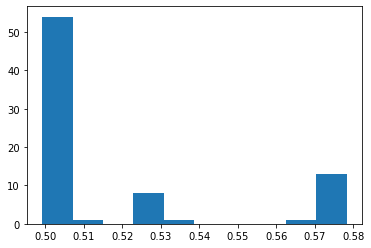

In [12]:
p_adj = adjust_p_value_qval(df['p-value'])
import matplotlib.pyplot as plt
plt.hist(df['p-value'], bins=10)
# plt.xlim([0, 0.9])
# plt.ylim([0, 100])
plt.show()
plt.hist(p_adj, bins=10)
plt.show()

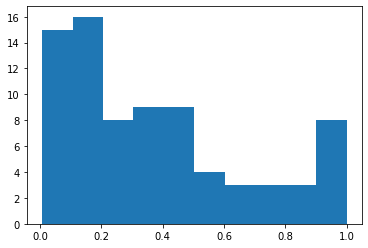

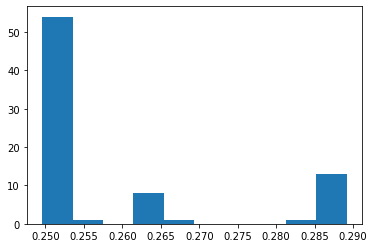

In [10]:
p_adj = adjust_p_value_qval(df['p-value'], pi_0=0.5)
import matplotlib.pyplot as plt
plt.hist(df['p-value'], bins=10)
# plt.xlim([0, 0.9])
# plt.ylim([0, 100])
plt.show()
plt.hist(p_adj, bins=10)
plt.show()

In [9]:
df['p-adj'] = p_adj

In [10]:
df[df['p-adj']<0.05]

,cluster_name,pathway_name,p-value,p-adj


In [86]:
adjust_p_value_fdr(df['p-value'])

0     0.029019
1     1.000000
2     0.891466
3     0.152219
4     0.745057
        ...   
73    0.187921
74    0.149926
75    1.000000
76    0.949185
77    0.505286
Name: p-value, Length: 78, dtype: float64